**MULTI-AGENT(SuperVisor)**

#requirements
pip install -U langgraph langgraph-supervisor langchain-tavily langchain_groq langchain_community langchain_tavily html2text  langgraph_supervisor


In [4]:
#testing LLM
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os

load_dotenv()

llm = ChatGroq(
    temperature=0,  # Lower temperature for more factual responses
    groq_api_key=os.getenv("GROQ_API_KEY"),
    model_name="llama-3.3-70b-versatile"
)


result=llm.invoke("Hello")
print(f"AI: {result.content}")

AI: Hello. How can I assist you today?


**1 Create Worker Agents**

First, lets create our specialized agents.


*   Research Agent
*   Administrator
*   Decryptor


**a) Research Agent**

For gathering information using Tavily Search tool, web scraping using the loader and also information on exploits from the exploit db.

In [5]:
#lets test the search tool
from langchain_tavily import TavilySearch
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("Exploiting FTP Anonymous")

print(web_search_results["results"][0]["content"])

5.   **Buffer Overflow**: This attack exploits vulnerabilities in FTP software by overwriting the application’s memory, potentially altering system functionality or exposing sensitive information. This application is vulnerable to a directory traversal attack, which enables an attacker to download, upload, and delete arbitrary files outside of the FTP server’s root directory. After downloading the exploit file from the provided link on Exploit-DB, we’re ready to proceed with exploiting the vulnerability in the HOME FTP Server application. As soon as the victim connects to the attacker’s FTP server, the exploit is triggered, allowing the attacker to gain control of the victim’s machine. The server allowed anonymous login, lacked brute force protection, and was susceptible to directory traversal attacks, XSS vulnerabilities, and buffer overflow exploits.


In [6]:
# Let's build the research agent tools
from langchain_tavily import TavilySearch
from langchain.tools import tool  # Correct import
from exploit_info import get_cve_info
from web_scrape import scrape_web_pages

# Tool 1 — Tavily Search Tool
web_search = TavilySearch(max_results=3)

# Tool 2 — CVE information
@tool
def exploit_search(query: str) -> str:
    """Use this to search CVEs on NVD for a certain service."""
    result = get_cve_info(query)
    return result

# Tool 3 — Web scraper for information from links
@tool
def web_scraper(query: list[str]) -> str:
    """Scrape and return page contents using LangChain's WebBaseLoader."""
    results = scrape_web_pages(query)
    return str(results)


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
#lets create the agent and add the tools
from langgraph.prebuilt import create_react_agent

research_agent=create_react_agent(
    model=llm,
    tools=[web_search,web_scraper, exploit_search],
    prompt=(
        "You are a Penetration Testing research agent.\n\n" \
        "INSTRUCTIONS:\n" \
        "You have three tools to help you with your research allowing you to be able to perform:"
        "web searches, query CVE information and web scraping to get more information from URLs." \
        "After you're done with your tasks, respond to the supervisor directly\n" \
        "Respond ONLY with the results of your work, do NOT include ANY other text"
    ),
    name="research_agent",
)

**b.) Terminal Agent**

For this Agent we will want to give it access to a Kali Linux Terminal.

In [9]:
#kali linux tools
from kali import connected_kali

@tool
def kali_linux(query:str)->str:
    """Access to a Kali Linux Terminal, useful for runing CLI tools during penetration testing and CTFs"""
    result=connected_kali(query)
    return result

terminal_agent=create_react_agent(
    model=llm,
    tools=[kali_linux],
    prompt=(
        "You are a Terminal Agent\n\n" \
        "INSTRUCTIONS:\n" \
        "-You have multiple inbuild Kali Linux inbuild CLI tools, if not installed run apt install <tool_name>"
        "-Assist ONLY with tasks related to execution of commands\n" \
        "-After youre done with your task, respond to the supervisor directly\n" \
        "-Respond ONLY with the results of your work, do NOT include aANY other text"
    ),
    name="terminal_agent",
)

**c.) Decrypt Agent**

Agent is responsible for identifying various forms of data hiding technigues(base64) and converstions including number converstion i.e binary, hex and decimal.

In [10]:
#write the tool first
from decode_encode import convert_from_b64, convert_to_b64, detect_base, convert_number

@tool
def convert_from_base64(query: str)->str:
    """Useful when we want to convert string from base64"""
    return convert_from_b64(query)

@tool
def convert_to_base64(query: str)->str:
    """Useful when converting string to base64"""
    return convert_to_b64(query)

@tool
def number_system_id(query: str)-> str:
    """Detects whether the string is hex, decimal or binary"""
    return detect_base(query)

@tool
def number_system_converter(value: str, source_format: str, target_format: str)->str:
    """
    Convert a number from source_format ('hex', 'binary', 'decimal')
    to target_format ('hex', 'binary', 'decimal').
    """
    return convert_number(value, source_format, target_format)


In [ ]:
#write the decrytor agent
decrypt_agent=create_react_agent(
    model=llm,
    tools=[convert_from_base64, convert_to_base64, number_system_id, number_system_converter],
    prompt=(
        "You are the Decryption Agent.\n\n" \
        "INSTRUCTIONS:" \
        "-Assist ONLY with decoding of base64, and number conversions\n" \
        "-After you're done with your tasks, respond to the supervisor directly\n"
        "-Respond ONLY with the results of your work, do NOT include ANY othaer text"
    ),
    name="decrypt_agent"
)


**2. Create Supervisor with langgraph-supervisor**

This handles all of our agents🥶

In [12]:
from langgraph_supervisor import create_supervisor

supervisor_graph = create_supervisor(
    model=llm,
    agents=[research_agent, terminal_agent, decrypt_agent],
    prompt=(
        "You are a Powerful Pentest supervisor managing three Security agents:\n"
        "- a research agent. Assign exploitation research-related tasks to this agent\n"
        "- a terminal agent. Assign Kali Linux command CLI execution tasks to this agent\n"
        "- a decrypt agent. Assign encoding (base64) and decoding tasks to this agent\n"
        "Assign work to one agent at a time. Do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_messages=True,  # correct argument
    add_handoff_back_messages=True,
    output_mode="full_history",
)

supervisor = supervisor_graph.compile()


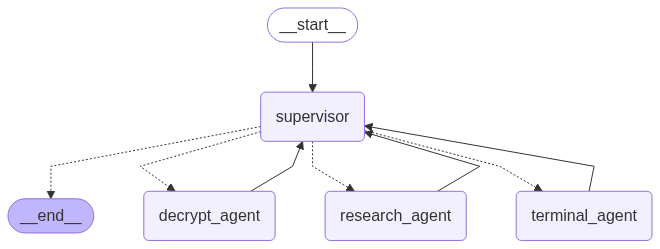

In [13]:
from IPython.display import display, Image
display(Image(supervisor.get_graph().draw_mermaid_png()))

Lets run our agent


In [17]:
#COMPILE AND RUN
result=supervisor.invoke({
    "messages": [
        {
            "role":"user",
            "content":"search for me about Ruto latest visit"
        }
    ]
})


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


[+] Searching CVEs for: Ruto latest visit CVEs
[-] No CVEs found.

[+] Scraping: https://www.zawya.com/en/press-release/africa-press-releases/south-sudans-minister-of-mines-to-showcase-ep-prospects-at-african-mining-week-amw-2025-e367q0lu
[-] Failed to scrape https://www.zawya.com/en/press-release/africa-press-releases/south-sudans-minister-of-mines-to-showcase-ep-prospects-at-african-mining-week-amw-2025-e367q0lu: No module named 'bs4'

[+] Scraping: https://apnews.com/article/congo-rwanda-peace-agreement-trump-us-minerals-f74d15074cbadf35bedf37316bc722a6
[-] Failed to scrape https://apnews.com/article/congo-rwanda-peace-agreement-trump-us-minerals-f74d15074cbadf35bedf37316bc722a6: No module named 'bs4'

[+] Scraping: https://www.semafor.com/article/07/02/2025/first-trump-africa-summit-to-be-held-next-week
[-] Failed to scrape https://www.semafor.com/article/07/02/2025/first-trump-africa-summit-to-be-held-next-week: No module named 'bs4'
